## Victor Rene Pérez Mayen
### 19005180
#### Tarea 3: reg. logistica

In [30]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_lab), (test_images, test_lab) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

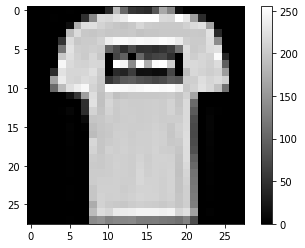

In [5]:
# 1ra Categoría
plt.imshow(train_images[1], cmap = 'gray')
plt.colorbar()

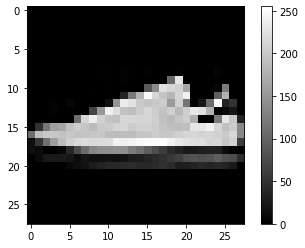

In [6]:
# 2da Categoría
plt.imshow(train_images[6], cmap = 'gray')
plt.colorbar()

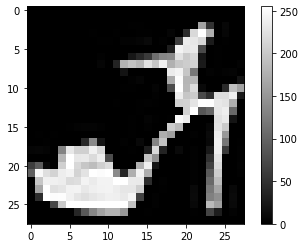

In [7]:
# 3ra Categoría
plt.imshow(train_images[9], cmap = 'gray')
plt.colorbar()

## Labels

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

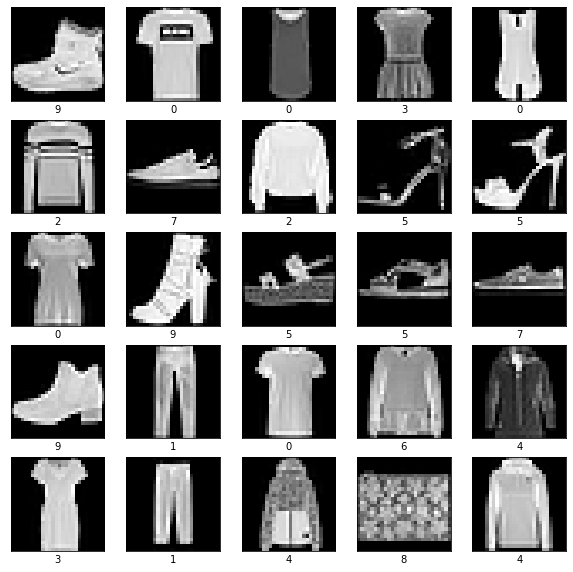

In [9]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalizaciÃ³n sobre el entrenamiento con regresiÃ³n logÃ­stica.
- Se debe crear un diccionario con el valor numÃ©rico de las labels y el texto correspondiente para poder relacionar el valor numÃ©rico con el valor descriptivo/textual.
- Aplicar regresiÃ³n logÃ­stica con entropÃ­a cruzada como funciÃ³n de costo, crear una funciÃ³n que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropÃ­a cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalizaciÃ³n y escalado)
- Basado en los ejemplos de visualizaciÃ³n de imagenes en el notebook ,crear una funciÃ³n que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como tÃ­tulo el nombre de la prenda con mayor probabilidad.
- Utilizar la funciÃ³n anterior para mostrar una muestra aleatoria de 5 imÃ¡genes(y la predicciÃ³n probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [69]:
# Acá se tienen que realizar el reshape de las imagenes por categorías.
cat = np.array([1,6,9])
train_cat = np.where((train_labels == cat[0])|(train_labels == cat[1])|(train_labels == cat[2]))
test_cat = np.where((test_labels == cat[0])|(test_labels == cat[1])|(test_labels == cat[2]))
train_re = np.copy(train_images[train_cat]) # Aca inicia el reshape de las imagenes
test_re = np.copy(test_images[test_cat]) # Se realizan copias de las variables para que no afecten a las originales directamente
train_shape = train_re.shape
test_shape = test_re.shape
train_re.resize((train_shape[0], train_shape[1]*train_shape[2]))
test_re.resize((test_shape[0], test_shape[1]*test_shape[2]))

(18000, 784)
(3000, 784)


In [77]:
# Acá se utiliza el one-shot encoding
lab = np.copy(cat) # Se crea otra copia de la categorización para el paquete de scikit
encoder = LabelEncoder()
cat = encoder.fit_transform(train_labels[train_cat])
train_y = np.eye(len(set(train_labels[train_cat])))[cat]
lab = np.copy(cat)
cat = encoder.fit_transform(test_labels[test_cat])
test_y = np.eye(len(set(test_labels[test_cat])))[cat]
num_test = test_y.shape[0]

print("dimensiones del train", train_re.shape) #dimensiones del train
print("dimensiones del test", test_re.shape) #dimensiones del test

print("dimensiones de la categorizacion de train", train_y.shape) #dimensiones de la categorizacion de train
print("dimensiones de la categorizacion de test", test_y.shape) #dimensiones de la categorizacion de test

dimensiones del train (18000, 784)
dimensiones del test (3000, 784)
dimensiones de la categorizacion de train (18000, 3)
dimensiones de la categorizacion de test (3000, 3)


In [73]:
tf.reset_default_graph()
grafo = tf.Graph() #Se construye el grafo
with grafo.as_default() as g:
    X = tf.placeholder("float", shape = [None, 784], name = "X_train")
    Y = tf.placeholder("float", shape = [None, 3], name = "Y_train")
    W = tf.Variable(tf.zeros([784, 3]), name = "W", dtype = "float")
    b = tf.Variable(tf.zeros([3]), name = "b", dtype = "float")
    learning_rate = tf.placeholder("float", name = "learning_rate")
    with tf.name_scope('Mult') as scope:
        mul = tf.add(tf.matmul(X, W), b)
    with tf.name_scope('Softmax') as scope:
        soft = tf.nn.softmax(mul, name = "Softmax")
    with tf.name_scope('Entropia_Cruzada') as scope:
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=soft))
        cost_summary = tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    with tf.name_scope("Prediccion") as scope:
        pred = tf.equal(tf.argmax(soft,1), tf.argmax(Y,1))
    with tf.name_scope("Accuracy") as scope:
        accuracy = tf.reduce_mean(tf.cast(pred, "float"))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
    group_summ = tf.summary.merge_all()
    init = tf.global_variables_initializer()

In [74]:
def entrenamiento(data_x, data_y, lr, t_epoch, batch_size, display_epoch, name):
    num_train = data_y.shape[0]
    t_batch = num_train//batch_size
        
    with tf.Session(graph = grafo) as sess:
        writer = tf.summary.FileWriter('./graphs/lr_prueba_'+name, sess.graph)
        sess.run(init)
        for epoch in range(t_epoch):
            resultado_costo = 0
            for bt in range(t_batch):
                batch_x = data_x[bt*batch_size:bt*batch_size+batch_size]
                batch_y = data_y[bt*batch_size:bt*batch_size+batch_size]
                sess.run(optimizer, feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
            if (epoch + 1) % display_epoch == 0:
                training_cost, weight, bias, acc = sess.run([cost, W, b, accuracy], feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
                s = sess.run(group_summ, feed_dict = {X: batch_x, Y: batch_y, learning_rate: lr})
                writer.add_summary(s, epoch+1)
                print("Epoch: ", (epoch + 1))
                print("Costo: ", training_cost)
                print("W: ", weight)
                print("b: ", bias)
                print("Accuracy: ", acc)
                print("----------------------------------------------")
        writer.close()
        return(weight, bias)

In [81]:
resultado_1, resultado_2 = entrenamiento(train_re, train_y, 0.002, 250, 32, 20, ".") #Construcción sin normalizar

Epoch:  20
Costo:  0.58269465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.8348456e-12]
 [-7.1226909e-09  7.1221171e-09 -1.8343679e-12]
 [-4.3653736e-07  1.8016108e-05 -1.7579570e-05]
 ...
 [ 8.4576575e-04 -4.1725670e-04 -4.2850940e-04]
 [ 2.2893987e-04 -1.2794106e-05 -2.1614631e-04]
 [-2.0315269e-24  1.1874708e-05 -1.1875013e-05]]
b:  [-1.0750095e-04  1.5702628e-04 -4.9525144e-05]
Accuracy:  0.96875
----------------------------------------------
Epoch:  40
Costo:  0.55144465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.8348456e-12]
 [ 1.9999132e-05 -1.9999126e-05 -1.8343679e-12]
 [ 5.2946899e-07  7.6973163e-05 -7.7502627e-05]
 ...
 [ 2.6327958e-03 -1.9986932e-03 -6.3410366e-04]
 [ 2.1349131e-03 -1.7023783e-03 -4.3253612e-04]
 [ 4.1143703e-05 -2.8028646e-05 -1.3115540e-05]]
b:  [-2.4193231e-04  3.3233422e-04 -9.0401678e-05]
Accuracy:  1.0
----------------------------------------------
Epoch:  60
Costo:  0.55144465
W:  [[ 0.0000000e+00  0.0000000e+00 -1.8348456e-12]
 [ 2.0722606e-05 -2.0722611e-05 

In [83]:
print(resultado_1)
print(resultado_2)

[[ 0.0000000e+00  0.0000000e+00 -1.8348456e-12]
 [ 2.2160388e-05 -5.7187481e-05  3.5027097e-05]
 [ 2.2685157e-05  2.3021423e-05 -4.5706565e-05]
 ...
 [-4.2399831e-04  2.9437973e-03 -2.5197996e-03]
 [ 3.2143705e-03 -2.2705926e-03 -9.4377983e-04]
 [-1.9219216e-04  2.1499106e-04 -2.2799424e-05]]
[-1.1766640e-03  1.2492179e-03 -7.2555151e-05]


In [84]:
norm_1, norm_2 = entrenamiento(train_re/255, train_y, 0.002, 200, 32, 20, ".") # Ya normalizado

Epoch:  20
Costo:  0.5859406
W:  [[-3.8847265e-06  8.7074286e-06 -4.8226984e-06]
 [-6.4608025e-06  9.6230033e-06 -3.1622051e-06]
 [-2.6529768e-05  7.8645149e-05 -5.2115454e-05]
 ...
 [-1.4322654e-03 -1.5079594e-03  2.9402317e-03]
 [-5.3511438e-04 -7.9872989e-04  1.3338480e-03]
 [-6.2769337e-05  1.5494004e-05  4.7275382e-05]]
b:  [-0.00724407  0.04311016 -0.03586603]
Accuracy:  0.96875
----------------------------------------------
Epoch:  40
Costo:  0.58431447
W:  [[-5.5514411e-06  1.2522233e-05 -6.9707939e-06]
 [-9.4038151e-06  1.4476512e-05 -5.0726935e-06]
 [-3.4387322e-05  1.0408853e-04 -6.9701186e-05]
 ...
 [-1.5998395e-03 -1.8336616e-03  3.4335293e-03]
 [-6.2168826e-04 -8.8434626e-04  1.5060401e-03]
 [-7.8478661e-05  7.3334151e-05  5.1447014e-06]]
b:  [-0.01996041  0.07331198 -0.0533515 ]
Accuracy:  0.96875
----------------------------------------------
Epoch:  60
Costo:  0.5837974
W:  [[-6.77473054e-06  1.52203847e-05 -8.44565511e-06]
 [-1.18106545e-05  1.83189477e-05 -6.50828679

In [85]:
print(norm_1)
print(norm_2)

[[-1.3138534e-05  2.7007825e-05 -1.3869290e-05]
 [-2.6217031e-05  3.9414950e-05 -1.3197735e-05]
 [-7.6769320e-05  2.1137645e-04 -1.3460356e-04]
 ...
 [-1.6196913e-03 -3.0609120e-03  4.6808664e-03]
 [-7.4687466e-04 -1.0884834e-03  1.8354893e-03]
 [-1.3173625e-04  4.2245208e-04 -2.9070812e-04]]
[-0.09778257  0.21356256 -0.11578087]


In [86]:
t_images = test_images[test_cat]
t_lab = test_labels[test_cat]

def prediccion(r_w, r_b, data_x, num_imagen):
    cat = np.array(["2 - Pullover","7 - Sneaker","9 - Ankle boot"])
    mul = np.matmul(data_x[num_imagen], r_w)+r_b
    soft = np.exp(mul-np.max(mul))/np.sum(np.exp(mul-np.max(mul)))
    kat = np.argmax(soft)
    print("Cat: ",cat[kat])
    print("Probabilidad: ",soft[kat])

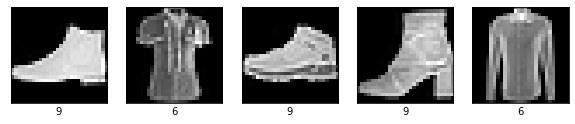

Cat:  9 - Ankle boot
Probabilidad:  1.0
Cat:  7 - Sneaker
Probabilidad:  1.0
Cat:  9 - Ankle boot
Probabilidad:  1.0
Cat:  9 - Ankle boot
Probabilidad:  1.0
Cat:  7 - Sneaker
Probabilidad:  1.0


In [87]:
random = np.random.randint(low = 0, high = test_re.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_lab[random[i]])
plt.show()
#No normalizado
for x in random:
    prediccion(resultado_1, resultado_2, test_re, x)

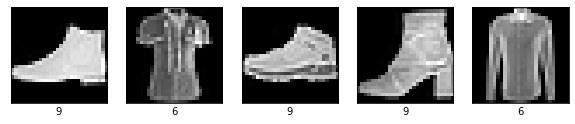

Cat:  9 - Ankle boot
Probabilidad:  0.9999657810407375
Cat:  7 - Sneaker
Probabilidad:  0.991585505515878
Cat:  9 - Ankle boot
Probabilidad:  0.989612533895864
Cat:  9 - Ankle boot
Probabilidad:  0.9999854270230095
Cat:  7 - Sneaker
Probabilidad:  0.9997454661960463


In [88]:
andom = np.random.randint(low = 0, high = test_re.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(t_images[random[i]], cmap='gray')
    plt.xlabel(t_lab[random[i]])
plt.show()
# Si normalizado
for x in random:
    prediccion(norm_1, norm_2, test_re/255, x)

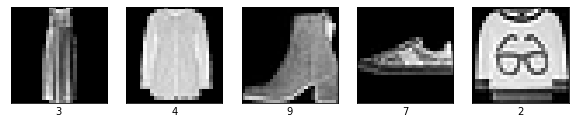

Cat:  2 - Pullover
Probabilidad:  0.7653269375574777
Cat:  7 - Sneaker
Probabilidad:  0.9999939287980307
Cat:  9 - Ankle boot
Probabilidad:  0.9995002439041653
Cat:  9 - Ankle boot
Probabilidad:  0.9388090690614537
Cat:  7 - Sneaker
Probabilidad:  0.9997796900742926


In [89]:
test_images_reshape = np.copy(test_images)
test_shape = test_images_reshape.shape

test_images_reshape.resize((test_shape[0], test_shape[1]*test_shape[2]))

random = np.random.randint(low = 0, high = test_images_reshape.shape[0], size = 5)
plt.figure(figsize=(10,10))
for i in range(len(random)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random[i]], cmap='gray')
    plt.xlabel(test_labels[random[i]])
plt.show()
#Si normalizado
for x in random:
    prediccion(norm_1, norm_2, test_images_reshape/255, x)

## Conclusiones

### - Se demuestra que al no normalizar los datos, las probabilidades tienden a ser 1, siendo este un error ya que no tendría sentido que la predicción sea 100% verídica.
### - Cuando se normalizan los datos, estos ya adquieren probabilidades mas coherentes.
### - El entrenamiento en las imagenes normalizadas tiende a tardarse menos tiempo que las no normalizadas, esto puede deberse a que las normalizadas estan siendo divididas dentro de 255.